<a href="https://colab.research.google.com/github/Wangadeveloper/huduma-online-cyber/blob/main/enefit_eda_catboost_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
#!pip install catboost
#!pip install optuna
#!pip install joblib
#!pip install pathlib
#!pip install typing
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import holidays

from catboost import CatBoostRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

import optuna
import joblib


from typing import Optional,Dict,Tuple
from pathlib import Path

plt.style.use("ggplot")
plt.rcParams.update(**{'figure.dpi': 150})

## Loading the data

In [41]:
#data_path = Path('/kaggle/input/predict-energy-behavior-of-prosumers')

train = pd.read_csv('train.csv', parse_dates=['datetime'])

train.head

<bound method NDFrame.head of         county  is_business  product_type    target  is_consumption  \
0            0            0             1     0.713               0   
1            0            0             1    96.590               1   
2            0            0             2     0.000               0   
3            0            0             2    17.314               1   
4            0            0             3     2.904               0   
...        ...          ...           ...       ...             ...   
157110      11            1             2     0.000               0   
157111      11            1             2    42.754               1   
157112      11            1             3     0.101               0   
157113      11            1             3  2974.479               1   
157114      12            1             3     0.000               0   

                   datetime  data_block_id    row_id  prediction_unit_id  
0       2021-09-01 00:00:00            0.0

## EDA

In [42]:
# check datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157115 entries, 0 to 157114
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   county              157115 non-null  int64  
 1   is_business         157115 non-null  int64  
 2   product_type        157115 non-null  int64  
 3   target              157115 non-null  float64
 4   is_consumption      157115 non-null  int64  
 5   datetime            157115 non-null  object 
 6   data_block_id       157114 non-null  float64
 7   row_id              157114 non-null  float64
 8   prediction_unit_id  157114 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 10.8+ MB


In [44]:
train['datetime']= pd.to_datetime(train['datetime'], errors='coerce')

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157114 entries, 0 to 157113
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   county              157114 non-null  int64         
 1   is_business         157114 non-null  int64         
 2   product_type        157114 non-null  int64         
 3   target              157114 non-null  float64       
 4   is_consumption      157114 non-null  int64         
 5   datetime            157114 non-null  datetime64[ns]
 6   data_block_id       157114 non-null  float64       
 7   row_id              157114 non-null  float64       
 8   prediction_unit_id  157114 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 12.0 MB


In [48]:
# missing values
train.isna().sum()

county                0
is_business           0
product_type          0
target                0
is_consumption        0
datetime              0
data_block_id         0
row_id                0
prediction_unit_id    0
dtype: int64

In [49]:
# drop missing values
# TODO: impute them instead
train = train.dropna(how='any')
train.shape[0]

157114

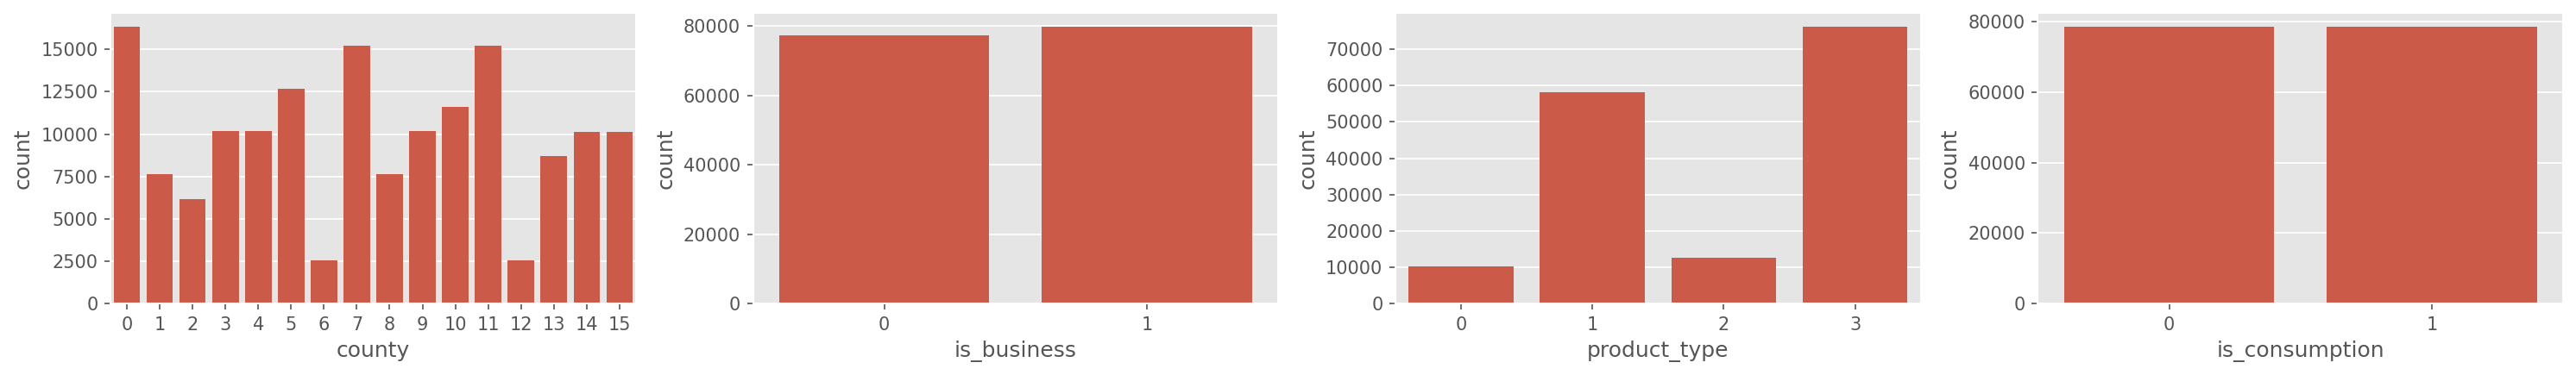

In [50]:
# counts for the country,store,product
desc_columns = ['county','is_business','product_type','is_consumption']

fig, axs = plt.subplots(1, len(desc_columns), figsize=(5*len(desc_columns), 3))

for i, column in enumerate(desc_columns):
    _ = sns.countplot(train, x=column, ax=axs[i])

_ = fig.tight_layout()

### Analyzing average production and consumption series

We plot the average production and consumption timeseries. Clearly, there are major differences in the trends and seasonal patterns. Therefore, it might be better to model the two series differently.

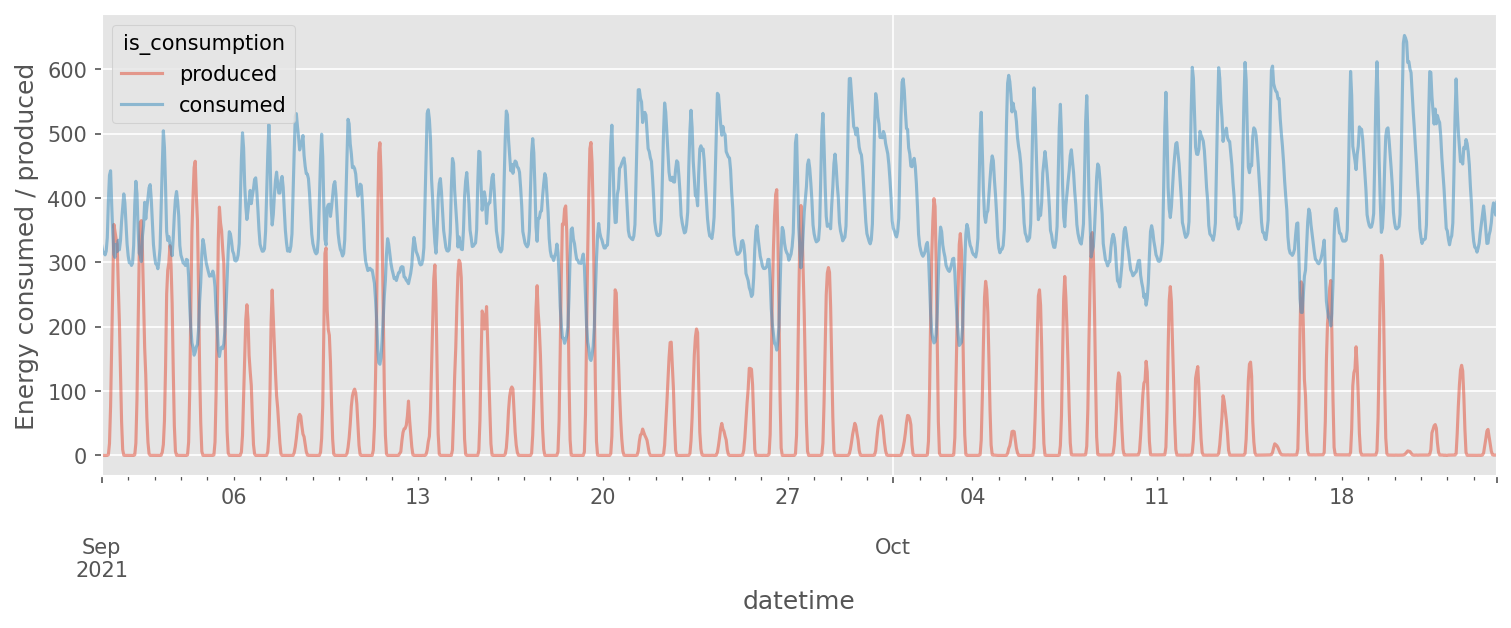

In [51]:
train_avgd = (
    train.groupby(['datetime','is_consumption'])['target'].mean().unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')

Here are the montly averages for the same series
1. The consumptions peaks in either January or February and is the least in the summer months
2. The reverse is true for the production series

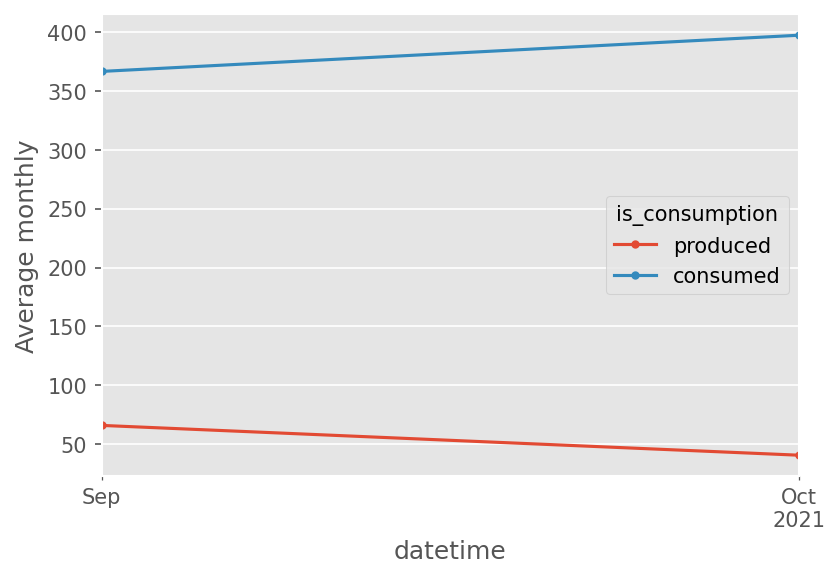

In [52]:
# plot of average weekly sales
fig,ax = plt.subplots(1,1,figsize=(6,4))
_ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Average monthly')

What about the patterns each hour? There seems to be a pattern for the produced series.

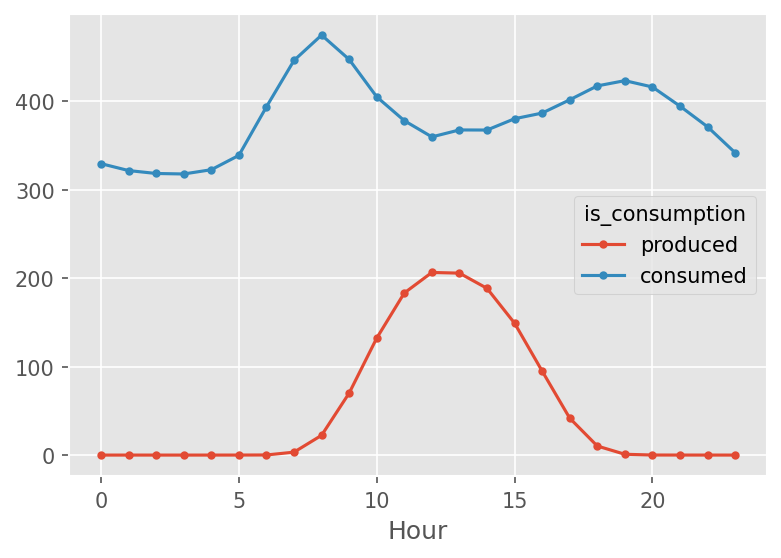

In [53]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')

## DateTime attributes

1. date
2. time: time in HH:MM:SS format
3. year
4. datediff_in_days: # days since the first observation in the training data
5. hour
6. dayofweek
7. week
8. month

For the last 4 features, we include sin and cosine transform to capture cyclical continuity.

In [54]:
earliest_time = train['datetime'].min()
def extract_dt_attributes(df:pd.DataFrame):
    # convert datetime column, if not done already
    df['datetime'] = pd.to_datetime(df['datetime'])

    # dates and times
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.strftime('%H:%M:%S')

    #
    df['year'] = df['datetime'].dt.year
    df['datediff_in_days'] = (
        df['datetime']- earliest_time
    ).dt.days

    # dictionary with time features as keys
    # and min and max as values
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }

    for col in time_features:
        if col=='week':
            df[col] = df['datetime'].dt.isocalendar().week.astype(np.int32)
        else:
            df[col] = getattr(df['datetime'].dt,col)


        ## sin and cosine features to capture the circular continuity
        col_min,col_max = time_features[col]
        angles = 2*np.pi*(df[col]-col_min)/(col_max-col_min+1)

        # add sin and cos
        df[col+'_sine'] = np.sin(angles).astype('float')
        df[col+'_cosine'] = np.cos(angles).astype('float')

In [55]:
%%time
# get train attributes
extract_dt_attributes(train)

CPU times: user 1.45 s, sys: 5.1 ms, total: 1.45 s
Wall time: 1.5 s


## Lagged targets

For the test data, we are given the targets 2 days prior. To use this information, we will create a feature for lagged targets 2 days prior.

In [56]:
%%time
shift = 2
train['data_block_id_shifted'] = train['data_block_id'] + shift

train = pd.merge(train,(train[['county', 'is_business','is_consumption',
                               'product_type','data_block_id_shifted',
                               'time', 'target']].rename(columns={'data_block_id_shifted':'data_block_id',
            'target':f'target_{shift}days_ago'})),
    on = ['county', 'is_business','is_consumption',
          'product_type', 'data_block_id', 'time'],how='left')

# drop the redundant column
del train['data_block_id_shifted']

train.head(2)

CPU times: user 140 ms, sys: 27.2 ms, total: 167 ms
Wall time: 166 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago
0,0,0,1,0.713,0,2021-09-01,0.0,0.0,0.0,2021-09-01,...,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN
1,0,0,1,96.590,1,2021-09-01,0.0,1.0,0.0,2021-09-01,...,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN


Clearly the target is very correlated with its lagged version. The degree of correlation is somewhat different across production and consumption patterns - the correlation is larger in the case of the consumption series.

In [57]:
# correlation between target and target_2_days_ago
(
    train[['is_consumption', 'target', 'target_2days_ago']].groupby('is_consumption')
    .corr().round(3)
)

target  target_2days_ago
is_consumption                                           
0              target             1.000             0.598
               target_2days_ago   0.598             1.000
1              target             1.000             0.935
               target_2days_ago   0.935             1.000

## Additional information

We will be looking at additional data in the following cells.

### Forecasted Electricity prices

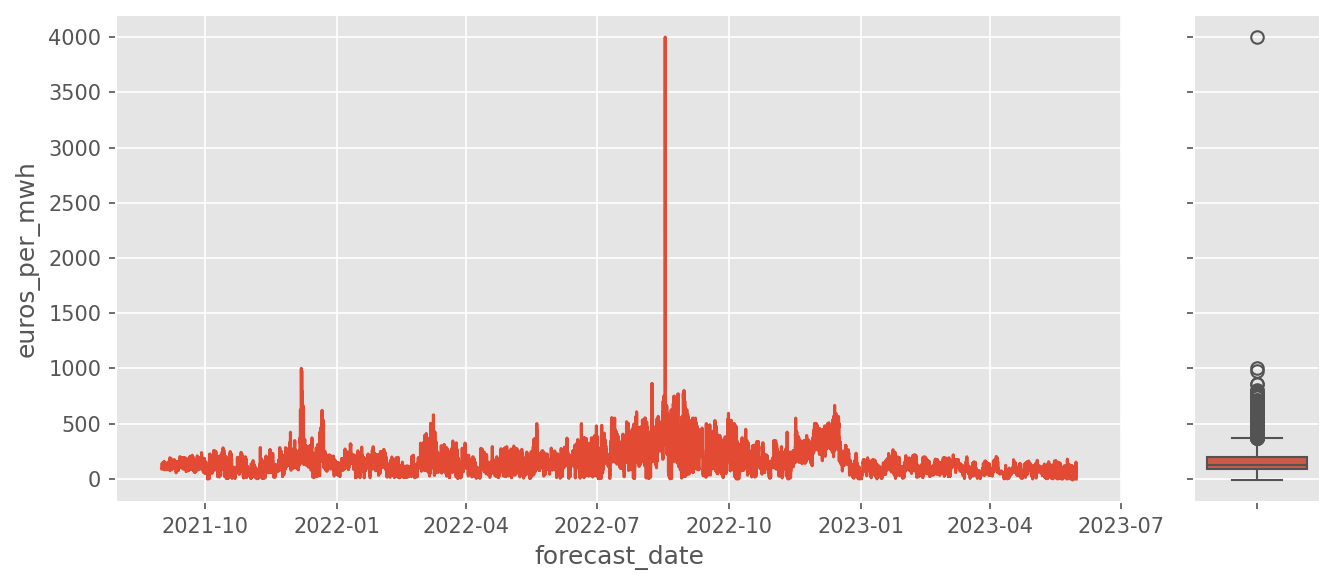

In [58]:
electricity_prices = pd.read_csv('electricity_prices.csv')
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
electricity_prices['time'] = electricity_prices['forecast_date'].dt.strftime('%H:%M:%S')

fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(electricity_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(electricity_prices, y='euros_per_mwh', ax=axs[1])
#_ = axs[1].get_yaxis().set_visible(False)
fig.tight_layout()

Here is the corresponding plot for the forecast for electricity prices averaged by day.

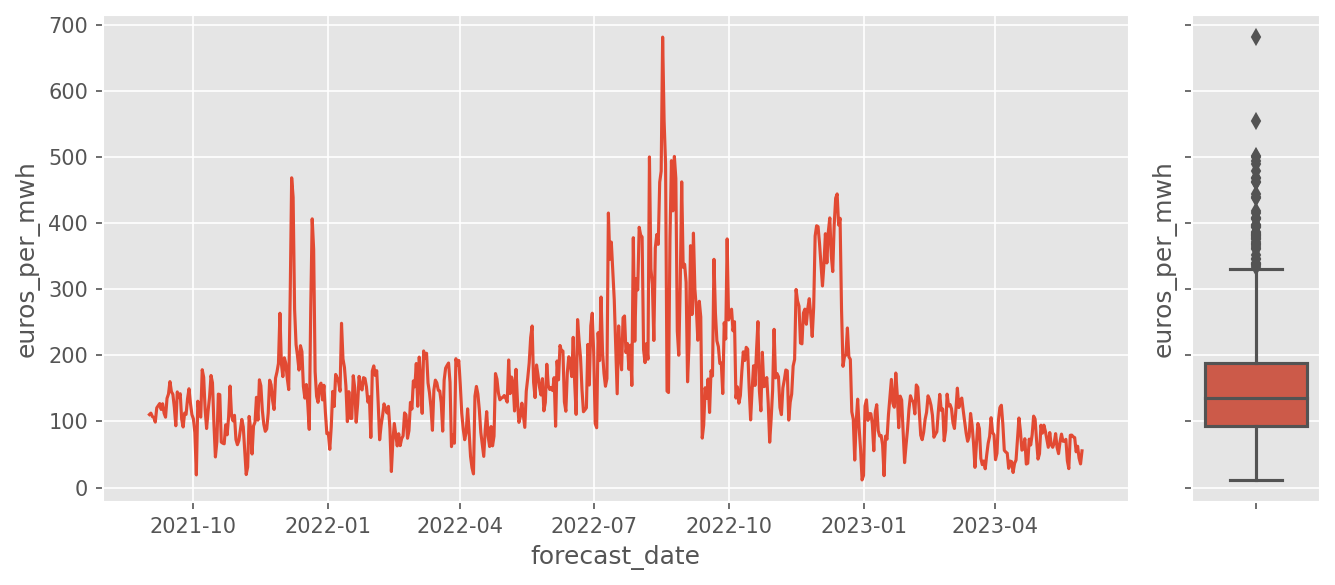

In [ ]:
daily_elec_prices = (
    electricity_prices[['forecast_date', 'euros_per_mwh']].set_index('forecast_date')
    .resample('D').mean())

fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(daily_elec_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(daily_elec_prices, y='euros_per_mwh', ax=axs[1])
#_ = axs[1].get_yaxis().set_visible(False)
fig.tight_layout()

In [59]:
%%time
# merge features
train = pd.merge(train,electricity_prices[['time', 'data_block_id', 'euros_per_mwh']],
    how = 'left',on = ['time', 'data_block_id'])

train.head()

CPU times: user 69.2 ms, sys: 18.8 ms, total: 88 ms
Wall time: 87.7 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago,euros_per_mwh
0,0,0,1,0.713,0,2021-09-01,0.0,0.0,0.0,2021-09-01,...,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0.0,1.0,0.0,2021-09-01,...,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0.0,2.0,1.0,2021-09-01,...,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0.0,3.0,1.0,2021-09-01,...,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0.0,4.0,2.0,2021-09-01,...,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN


### Gas prices

Unlike the electricity price forecasts, these are daily forecasts and not hourly forecasts.

In [60]:
gas_prices =  pd.read_csv('gas_prices.csv')
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])

gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


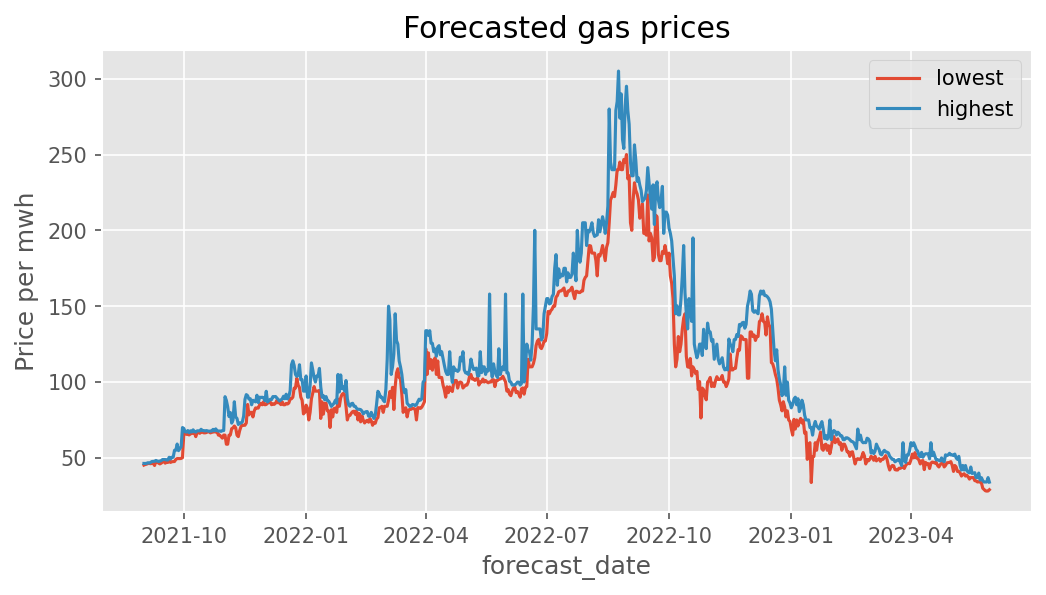

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
_ = sns.lineplot(gas_prices, x='forecast_date', y='lowest_price_per_mwh', ax=ax, label='lowest')
_ = sns.lineplot(gas_prices, x='forecast_date', y='highest_price_per_mwh', ax=ax, label='highest')
_ = ax.legend()
_ = ax.set_ylabel('Price per mwh')
_ = ax.set_title('Forecasted gas prices')

In [62]:
# merge features
train = pd.merge(
    train,
    gas_prices[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
    how = 'left',
    on = ['data_block_id']
)

train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.713,0,2021-09-01,0.0,0.0,0.0,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0.0,1.0,0.0,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0.0,2.0,1.0,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0.0,3.0,1.0,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0.0,4.0,2.0,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN


### Client information

In [63]:
client = pd.read_csv('client.csv')
# merge features
train = pd.merge(
    train,
    client.drop('date', axis=1),
    on = ['data_block_id', 'product_type', 'county', 'is_business'],
    how='left'
)
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,week_cosine,month,month_sine,month_cosine,target_2days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
0,0,0,1,0.713,0,2021-09-01,0.0,0.0,0.0,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0.0,1.0,0.0,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0.0,2.0,1.0,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0.0,3.0,1.0,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0.0,4.0,2.0,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN


### Correlations between target and additional features


The electricity and gas prices don't seem to be correlated at all. However, the client features seem to be moderately correlated with the target. However, for the consumption series, `installed_capacity` is highly correlated with the target.

In [64]:
# correlation between target and additional features
(
    train[[
        'is_consumption', 'target',
        # electricity prices
        'euros_per_mwh',
        # gas prices
        'lowest_price_per_mwh', 'highest_price_per_mwh',
        # client data
        'eic_count', 'installed_capacity'
    ]]
    .groupby('is_consumption')
    .corr()
    ['target']
    .unstack()
    .iloc[:, 1:]
    .round(3)
)

,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
is_consumption,,,,,
0,-0.011,-0.059,-0.068,0.335,0.337
1,0.040,0.014,0.017,0.327,0.848


## Preparing the data

In [65]:
not_feature_columns = [
    'datetime',
    'row_id',
    'prediction_unit_id',
    'date',
    'time'
]

In [66]:
# sort training dataset by datetime
X = train.drop(['target', 'data_block_id'] + not_feature_columns, axis=1)
y = train['target']

In [67]:
# unique year-month combinations - will be used in cross-validation
timesteps = np.sort(np.array(
    pd.to_datetime(X[['year', 'month']].assign(day=1)).unique().tolist()))
timesteps

array([1630454400000000000, 1633046400000000000])

## Catboost model

In [68]:
def fit_model(
    X:pd.DataFrame,
    y:pd.Series,
    config:Optional[Dict]=None,
    n_jobs:int=1,
    verbose:int=0
) -> CatBoostRegressor:
    '''
    Train a catboost regressor with L1 loss
    '''
    model = CatBoostRegressor(
        n_estimators=100,
        objective='MAE',
        thread_count=n_jobs,
        bootstrap_type =  "Bernoulli",
        sampling_frequency= 'PerTree',
        verbose=verbose,
        cat_features=['county', 'product_type'],
        leaf_estimation_iterations=1
    )

    if config:
        # if config is supplied, set the model hyperparameters
        model.set_params(**config)


    return model.fit(X,y)

### Hyperparameter tuning via Optuna

In [73]:
def fit_and_test_fold(config:Dict, X, y, year_month_train, year_month_test) -> float:
    first_dates_month = pd.to_datetime(X[['year', 'month']].assign(day=1))

    train_index = first_dates_month.isin(year_month_train)
    test_index = first_dates_month.isin(year_month_test)

    X_train = X[train_index];X_test = X[test_index]
    y_train = y[train_index]; y_test = y[test_index]

    # fit model on training data
    model = fit_model(X_train, y_train, config, n_jobs=4)

    # generate predictions
    y_test_pred = model.predict(X_test)

    return mean_absolute_error(y_test, y_test_pred)

# loss function
def objective(trial):
    config = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.95,log=True),
        'depth': trial.suggest_int('depth', 3, 10, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',1e-8,100,log=True),
        'model_size_reg': trial.suggest_float('model_size_reg',1e-8,100,log=True),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.1, 1),
        'subsample': trial.suggest_float("subsample", 0.5, 1)
    }

    cv = TimeSeriesSplit(n_splits=3)
    cv_mae = [None]*3
    for i, (train_index, test_index) in enumerate(cv.split(timesteps)):
        cv_mae[i] = fit_and_test_fold(config, X, y, timesteps[train_index], timesteps[test_index])

    # saving the individual fold holdout metrics
    # uncomment this line if you don't want this
    trial.set_user_attr('split_mae', cv_mae)

    return np.mean(cv_mae)


sampler = optuna.samplers.TPESampler(
    n_startup_trials=10, seed=1234
)

study = optuna.create_study(
    directions=['minimize'],sampler=sampler,study_name='catboost'
)

# maximum of 50 trials or 2 hr wall clock time
study.optimize(objective, n_trials=50, timeout= 7200)
_ = joblib.dump(study, 'catboost_enefit_hyperopt.pkl')

[I 2024-02-03 08:19:06,417] A new study created in memory with name: catboost
[W 2024-02-03 08:19:06,422] Trial 0 failed with parameters: {'n_estimators': 78, 'learning_rate': 0.16996488374291047, 'depth': 5, 'l2_leaf_reg': 0.7138152748525232, 'model_size_reg': 0.6306059747250776, 'colsample_bylevel': 0.3453333447543775, 'subsample': 0.6382321275715483} because of the following error: ValueError('Cannot have number of folds=4 greater than the number of samples=2.').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-73-6048c1ea390c>", line 32, in objective
    for i, (train_index, test_index) in enumerate(cv.split(timesteps+6)):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py", line 1129, in split
    raise ValueError(
ValueError: Cannot have number of folds=4 greater than the number of samples=2.
[W 2024-02-03 08

ValueError: Cannot have number of folds=4 greater than the number of samples=2.

In [ ]:
fig = optuna.visualization.plot_optimization_history(study, target_name='Validation MAE')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

In [ ]:
# get results
results = study.trials_dataframe(attrs=('number','value','duration', 'params'))
results = results.rename(columns={'value':'mae'})
results['duration'] = results['duration']/np.timedelta64(1, 's')
results = results.sort_values(by='mae',ascending=True)
results.to_csv(f'mae_catboost.csv',index=False)
results.head(10)


,number,mae,duration,params_colsample_bylevel,params_depth,params_l2_leaf_reg,params_learning_rate,params_model_size_reg,params_n_estimators,params_subsample
12,12,81.499160,242.553136,0.986476,7,3.706222e-08,0.281119,0.396349,196,0.740230
34,34,84.272093,179.393947,0.995464,5,3.107015e-07,0.167297,2.922973,177,0.650082
19,19,84.995953,217.732590,0.772738,8,1.562207e-07,0.280522,4.115257,182,0.605634
29,29,85.675251,135.337867,0.944679,5,5.611272e-07,0.429398,1.524053,128,0.641903
37,37,86.173107,136.195674,0.775629,5,1.135748e-08,0.239256,0.167675,135,0.688249
13,13,86.310885,248.463986,0.987633,7,4.144708e-07,0.308558,92.689465,199,0.772176
17,17,86.339905,169.170557,0.994084,6,7.050285e-06,0.552452,5.706603,147,0.699033
38,38,86.490039,122.011042,0.950298,6,3.721900e-06,0.179516,2.683333,113,0.582562
16,16,87.274855,244.960297,0.801675,8,1.098251e-06,0.342210,0.040707,184,0.798252
31,31,87.335680,213.146546,0.942635,6,4.714187e-07,0.453162,1.287533,189,0.683187


### Final model



In [ ]:
model = fit_model(X, y, n_jobs=4, config=study.best_params, verbose=20)

0:	learn: 247.7987955	total: 949ms	remaining: 3m 5s
20:	learn: 80.6166299	total: 16.7s	remaining: 2m 19s
40:	learn: 77.9988760	total: 32.2s	remaining: 2m 1s
60:	learn: 71.8293258	total: 47.9s	remaining: 1m 45s
80:	learn: 67.3393004	total: 1m 2s	remaining: 1m 29s
100:	learn: 64.4896394	total: 1m 18s	remaining: 1m 13s
120:	learn: 62.4471204	total: 1m 33s	remaining: 57.9s
140:	learn: 61.3185938	total: 1m 48s	remaining: 42.4s
160:	learn: 59.6577564	total: 2m 3s	remaining: 26.9s
180:	learn: 58.5554344	total: 2m 18s	remaining: 11.5s
195:	learn: 57.8624840	total: 2m 30s	remaining: 0us


In [ ]:
# save model
model.save_model('catboost_energy_pred.cbm',format='cbm')

In [ ]:
# Sanity check
y_pred = model.predict(X)
train_mae = mean_absolute_error(y, y_pred)
print(f'Train MAE: {train_mae:.3f}')

Train MAE: 57.869


### Gain based feature importances

Notes:

1. Feature importance measures from tree based models such as catboost can be misleading.
2. In catboost, the default feature importance measure is based on the total gain from splits involving the feature.

<Axes: >

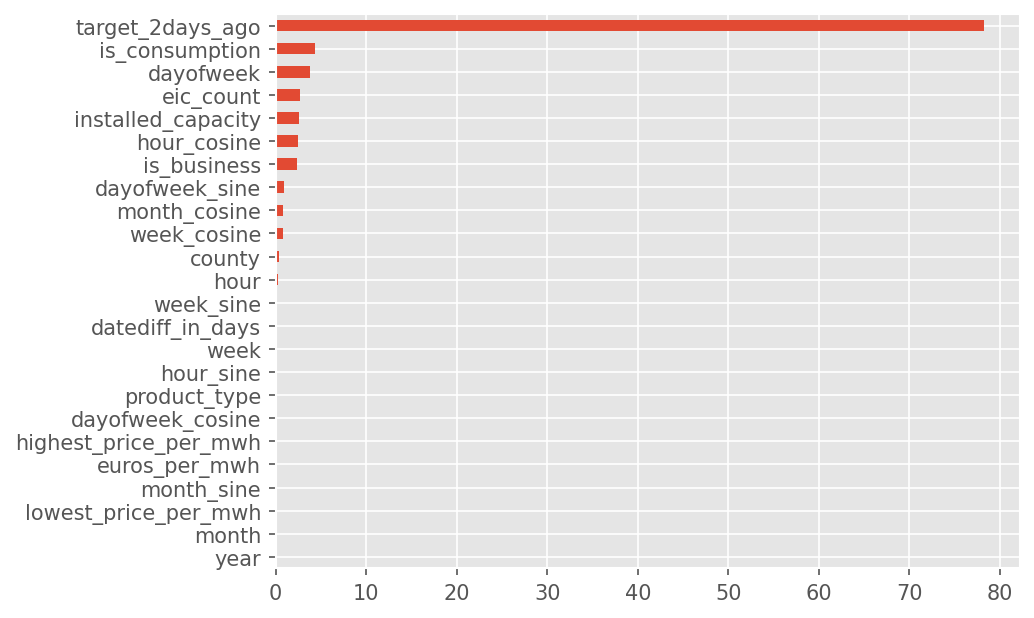

In [ ]:
# gain based feature importances - not necessarily the most reliable
feat_imp = pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')

## Function to create the final dataframe

Both feature engineering and additional features

In [ ]:
def get_final_df(df, revealed_targets, client, electricity_prices, gas_prices):

    # get datetime features
    extract_dt_attributes(df)

    ### Target 2 days ago ####
    revealed_targets = revealed_targets.rename(columns={'target':'target_2days_ago'})
    revealed_targets['datetime'] = pd.to_datetime(revealed_targets['datetime']) + pd.Timedelta(days=2)
    df = pd.merge(
        df,
        revealed_targets[
            ['county', 'is_business','is_consumption','product_type', 'datetime', 'target_2days_ago']
        ],
        how='left',
        on=['county', 'is_business','is_consumption','product_type', 'datetime']
    )

    ### Electricity prices ####
    electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
    electricity_prices['time'] = electricity_prices['forecast_date'].dt.strftime('%H:%M:%S')
    electricity_prices['date'] = (electricity_prices['forecast_date'] + pd.Timedelta(days=1)).dt.date

    df = pd.merge(
        df, electricity_prices[['time', 'date', 'euros_per_mwh']],
        how = 'left',
        on = ['time', 'date']
    )

    ### Gas prices ###

    gas_prices['date'] = (pd.to_datetime(gas_prices['forecast_date']) + pd.Timedelta(days=1)).dt.date

    df = pd.merge(
        df, gas_prices[['date', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
        how = 'left',
        on = ['date']
    )

    ### Client information ###
    client['date'] = (client['date'] + pd.Timedelta(days=2)).dt.date

    df = pd.merge(
        df, client,
        how='left',
        on = ['date', 'product_type', 'county', 'is_business'],
    )

    return df


## Submission on test set



In [ ]:
import enefit
env = enefit.make_env()
iter_test = env.iter_test()

for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:

    test = test.rename(columns={'prediction_datetime':'datetime'})
    test = get_final_df(test, revealed_targets, client, electricity_prices, gas_prices)

    X_test = test.drop(not_feature_columns, axis=1)

    sample_prediction['target'] = model.predict(X_test)
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
